In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Functions

## Plotting

In [10]:
def plot_graph(df, x_col = "Date", y_col = "Close", title = "S&P 500",
                        xlabel = 'Year', ylabel = 'Close value', start = "", end = ""):
    plt.figure(figsize=(10, 7))
    plt.plot(df[x_col], df[y_col])
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.show()
    return df

def plot_diff_series(df, x_col = "Date", y_col = "Log_Close", periods=365, xlabel= "Year", ylabel = 'Close value change',
                    title = "Differentiated Series Yearly"):
    df_diff = df.copy()
    df_diff = df_diff.set_index(x_col)
    df_diff=df_diff.diff(periods=periods)
    df_diff=df_diff.dropna() 

    plt.figure(figsize=(10, 7))
    plt.plot(df_diff.index, df_diff[y_col])
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    return df_diff

def decompose_time_series(df, x_col = "Date", y_col = "Log_Close", period = 365):
    decomposition = seasonal_decompose(df[y_col], model='additive', period=period)

    plt.figure(figsize=(10, 7))

    plt.subplot(411)
    plt.plot(df[x_col],df[y_col], label='Original')
    plt.legend(loc='upper left')
    plt.title('Original Series')

    plt.subplot(412)
    plt.plot(df[x_col],decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.title('Trend Component')

    plt.subplot(413)
    plt.plot(df[x_col],decomposition.seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    plt.title('Seasonal Component')

    plt.subplot(414)
    plt.plot(df[x_col],decomposition.resid, label='Residuals')
    plt.legend(loc='upper left')
    plt.title('Residual Component')

    plt.tight_layout()
    plt.show()
    df_out = pd.DataFrame({"Date": df["Date"], "seasonal": decomposition.seasonal,
                          "trend": decomposition.trend, "resid":decomposition.resid})
    return df_out

def plot_org_w_pred(data):
    ax = data["Log_Close"].plot(label='Observed', figsize=(10, 5))
    data["Forecast"].plot(ax=ax, label='Forecast', legend=True)
    plt.legend()
    plt.show()

## Processing

In [11]:
def make_full_dates_df(sp500):
    full_sp500 = pd.DataFrame({
        "Date": pd.date_range(sp500["Date"].iloc[0], sp500["Date"].iloc[-1], freq="D")
    })
    
    full_sp500 = full_sp500.merge(sp500, on="Date", how="left")
    full_sp500["Open"].ffill(inplace=True)
    full_sp500["Close"].ffill(inplace=True)
    full_sp500["Adj Close"].ffill(inplace=True)
    full_sp500["Volume"].fillna(0, inplace=True)
    full_sp500["Low"].fillna(full_sp500["Close"], inplace=True)
    full_sp500["High"].fillna(full_sp500["Close"], inplace=True)
    
    return full_sp500

def split_data(data, validation_years=2):
    validation_start_date = data.index.max() - pd.DateOffset(years=validation_years)
    train_data = data[data.index < validation_start_date]
    validation_data = data[data.index >= validation_start_date]
    return train_data, validation_data

def create_inout_sequences(input_data, train_seq_len, prediction_len=1):
    inout_seq = []
    L = len(input_data)
    for i in range(L-train_seq_len-prediction_len+1):
        train_seq = input_data[i:i+train_seq_len]
        train_label = input_data[i+train_seq_len:i+train_seq_len+prediction_len]
        inout_seq.append((train_seq, train_label))
    return inout_seq

## LSTM functions

In [12]:
def create_dataloader(sequences, batch_size=128, shuffle=True, num_workers=4, persistent_workers=False):
    dataset = TensorDataset(torch.FloatTensor([i[0] for i in sequences]), 
                            torch.FloatTensor([i[1] for i in sequences]))
    loader = DataLoader(dataset, shuffle=shuffle, batch_size=batch_size, 
                        num_workers=num_workers, persistent_workers=persistent_workers)
    return loader

class CustomLSTM(pl.LightningModule):
    def __init__(self, input_size=1, hidden_layer_sizes=[100, 50], output_size=1, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        
        self.lstm_layers = nn.ModuleList()
        for i, hidden_size in enumerate(hidden_layer_sizes):
            input_dim = input_size if i == 0 else hidden_layer_sizes[i-1]
            self.lstm_layers.append(nn.LSTM(input_dim, hidden_size, batch_first=True))
        
        self.linear = nn.Linear(hidden_layer_sizes[-1], output_size)

    def forward(self, input_seq):
        current_input = input_seq
        for lstm in self.lstm_layers:
            lstm_out, _ = lstm(current_input)
            current_input = lstm_out
        last_time_step_outputs = current_input[:, -1, :]
        predictions = self.linear(last_time_step_outputs)
        return predictions

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        seq, labels = batch
        y_pred = self(seq.view(-1, seq_length, 1)) 
        loss = nn.MSELoss()(y_pred, labels)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        seq, labels = batch
        y_pred = self(seq.view(-1, seq_length, 1)) 
        val_loss = nn.MSELoss()(y_pred, labels)
        self.log('val_loss', val_loss, on_epoch=True, prog_bar=True)
        return val_loss
    
def train_model(train_loader, validation_loader, input_size=1, hidden_layer_sizes=[100, 50], 
                output_size=1, learning_rate=0.001, max_epochs=10, name = "lightning_logs"):
    model = CustomLSTM(input_size=input_size, hidden_layer_sizes=hidden_layer_sizes, 
                       output_size=output_size, learning_rate=learning_rate)
    csv_logger = pl_loggers.CSVLogger(save_dir="logs/", name=name)
    trainer = pl.Trainer(max_epochs=max_epochs, logger=csv_logger)
    trainer.fit(model, train_loader, validation_loader)
    return model

def predict_iterativly(data, start_pred_point = "2019-11-06",
                       prediction_period = 365, add_forcast_to_frame=False):
    predictions = torch.empty(0)
    train_data = data[data.index<start_pred_point]
    predictions_dates = data[data.index>=start_pred_point].index
    inference_input = train_data[-seq_length:]["Log_Close"].tolist()
    inference_input_tensor = torch.FloatTensor(inference_input).unsqueeze(0).unsqueeze(-1)
    for i in range(prediction_period//prediction_len + int(prediction_period%prediction_len > 0)):
        model.eval()
        pred = model(inference_input_tensor)[0]
        predictions = torch.cat((predictions, pred))
        inference_input_tensor = torch.cat((inference_input_tensor[:,prediction_len:, :], pred.unsqueeze(0).unsqueeze(-1)), dim = 1)
    predictions = predictions.detach().numpy()[:prediction_period]
    if add_forcast_to_frame:
        data["Forecast"] = np.nan
        data.loc[np.isin(data.index, predictions_dates), "Forecast"] = predictions
        return data
    return predictions_dates

## SARIMA

In [13]:
def forecast_with_sarimax(time_series, forecast_periods, order, seasonal_order, xlabel = 'Year',
                          ylabel = 'Log Close Price', freq='MS', plot=True, offset = 0, title = "", forcast_next = False):
    if forcast_next:
        sarima_model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
    else:
        sarima_model = SARIMAX(time_series[:-forecast_periods - offset], order=order, seasonal_order=seasonal_order)
    sarima_model_fit = sarima_model.fit(disp=False)

    next_periods_forecast = sarima_model_fit.get_forecast(steps=forecast_periods)
    next_periods_ci = next_periods_forecast.conf_int()
    
    if forcast_next:
        future_dates = pd.date_range(start=time_series.index[-1], periods=forecast_periods, freq=freq)
    else:
        future_dates = pd.date_range(start=time_series.index[-forecast_periods - offset], periods=forecast_periods, freq=freq)
    next_periods_ci.index = future_dates

    futureDF_forecast = pd.DataFrame(next_periods_forecast.predicted_mean, index=future_dates)

    if plot:
        if offset == 0:
            ax = time_series.plot(label='Observed', figsize=(10, 5))
        else:
            ax = time_series[:-offset].plot(label='Observed', figsize=(10, 5))
        futureDF_forecast.plot(ax=ax, label='Forecast', legend=True)
        
        ax.fill_between(next_periods_ci.index,
                        next_periods_ci.iloc[:, 0],
                        next_periods_ci.iloc[:, 1], color='k', alpha=.1)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        plt.legend()
        plt.show()
    return futureDF_forecast, next_periods_ci

# Data loading

In [14]:
sp500 = pd.read_csv("SPY1950.csv")
sp500["Date"] = pd.to_datetime(sp500["Date"], format = "%d/%m/%Y")
sp500 = make_full_dates_df(sp500)
sp500["Log_Close"] = np.log(sp500["Close"])

In [15]:
sp500.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Log_Close
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000.0,2.813011
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000.0,2.824351
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000.0,2.829087
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000.0,2.832036
4,1950-01-07,16.98,16.98,16.98,16.98,16.98,0.0,2.832036


In [16]:
# date_diff = sp500["Date"].dt.month[1:].values - sp500["Date"].dt.month[:-1].values
# monthly_data = sp500[:-1][np.isin(date_diff, [1,-11])]
monthly_data = sp500[sp500["Date"].dt.day == 1]
monthly_data.reset_index(inplace = True, drop = True)
monthly_data["Log_Close"] = np.log(monthly_data["Close"])

# Plotting the data

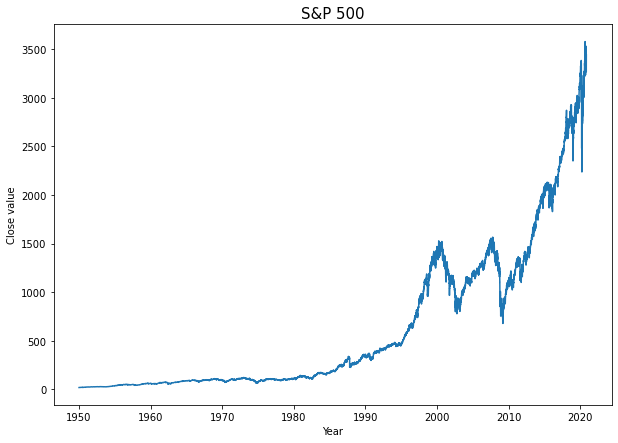

In [17]:
plot_graph(sp500);

this graph is rather exponential, lets take a look at the Log Close value

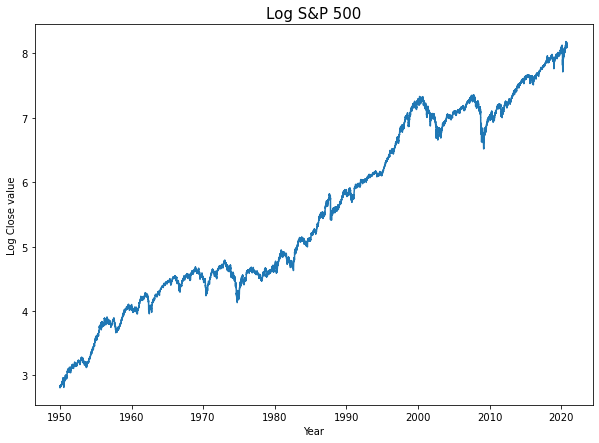

In [18]:
plot_graph(sp500, y_col= "Log_Close", ylabel = "Log Close value" , title = "Log S&P 500");

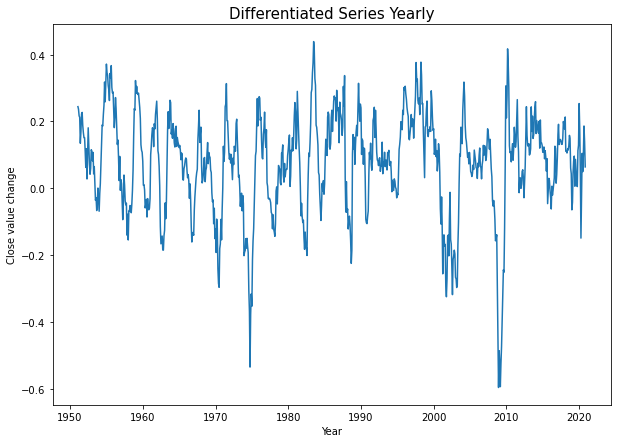

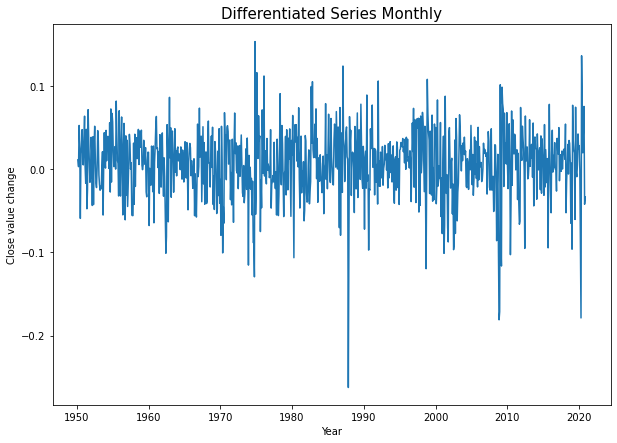

In [19]:
monthly_data_diff_Y = plot_diff_series(monthly_data, periods = 12)
monthly_data_diff_M = plot_diff_series(monthly_data, periods = 1, title = "Differentiated Series Monthly")

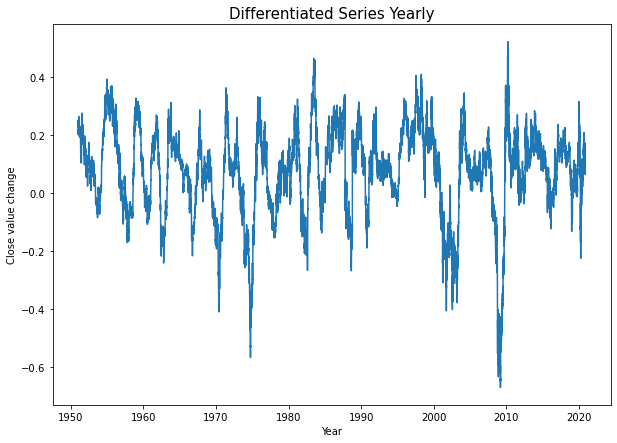

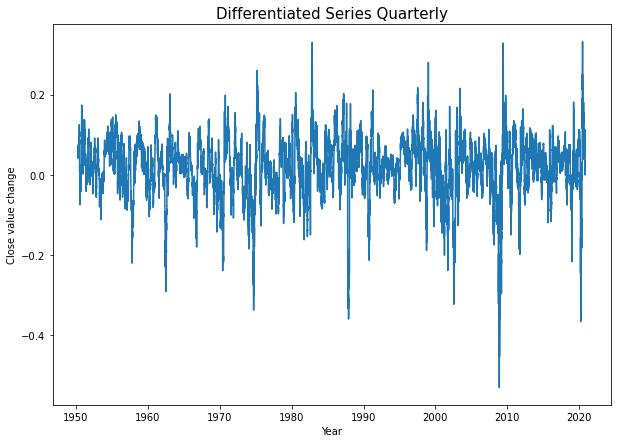

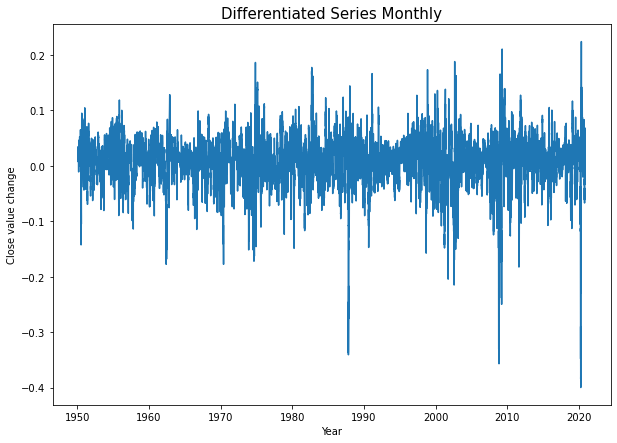

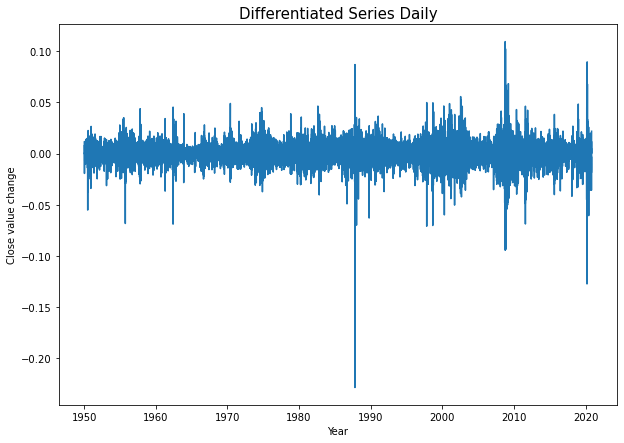

In [20]:
sp500_diff_Y = plot_diff_series(sp500)
sp500_diff_Q = plot_diff_series(sp500, periods=365//4, title = "Differentiated Series Quarterly")
sp500_diff_M = plot_diff_series(sp500, periods=365//12, title = "Differentiated Series Monthly")
sp500_diff_D = plot_diff_series(sp500, periods=1, title = "Differentiated Series Daily")

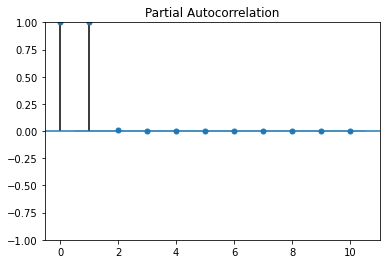

In [21]:
tsaplots.plot_pacf(sp500["Log_Close"], lags=10);

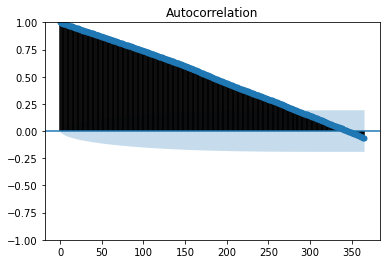

In [22]:
tsaplots.plot_acf(sp500_diff_Y["Log_Close"], lags=365);

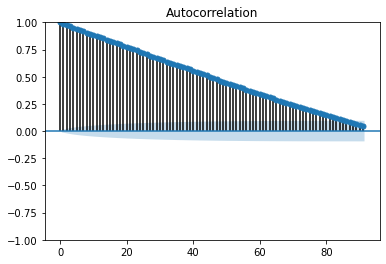

In [23]:
tsaplots.plot_acf(sp500_diff_Q["Log_Close"], lags=365//4);

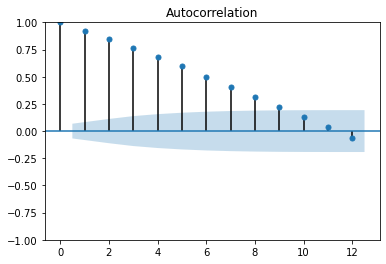

In [24]:
tsaplots.plot_acf(monthly_data_diff_Y["Log_Close"], lags=12);

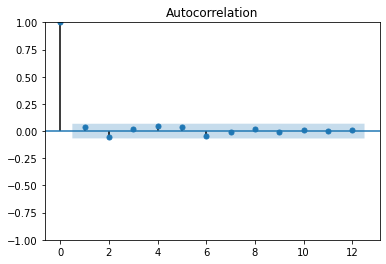

In [25]:
tsaplots.plot_acf(monthly_data_diff_M["Log_Close"], lags=12);

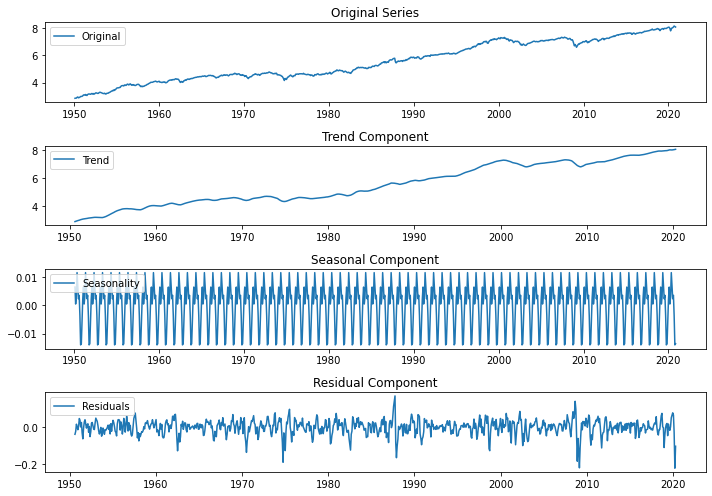

In [26]:
decomposition_year_montly = decompose_time_series(monthly_data, y_col = "Log_Close", period = 12)

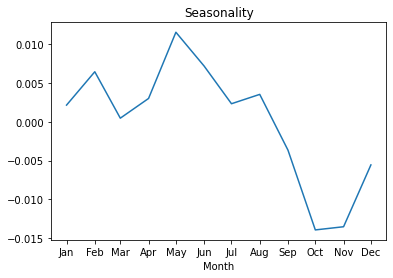

In [27]:
plt.plot(decomposition_year_montly["Date"][11:23],decomposition_year_montly["seasonal"][11:23])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel("Month")
plt.title("Seasonality")
plt.plot();

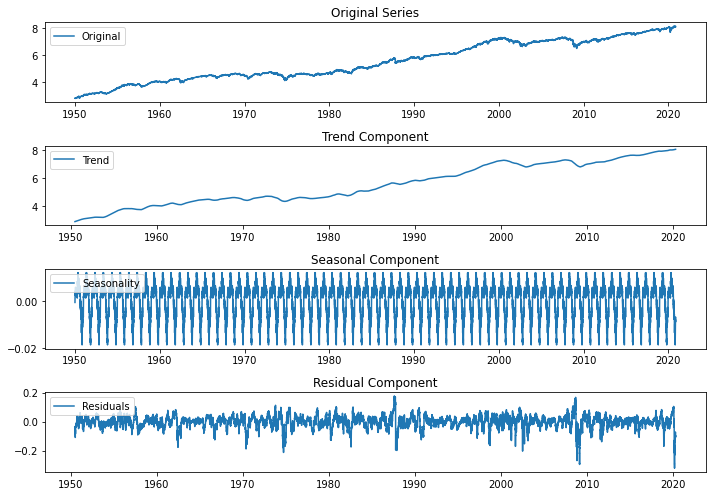

In [28]:
decomposition_year = decompose_time_series(sp500, y_col = "Log_Close", period = 365)

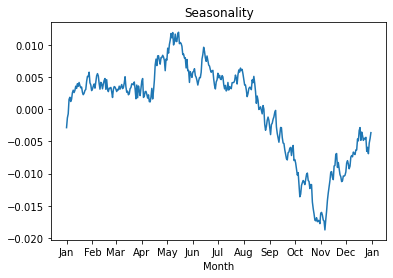

In [29]:
plt.plot(decomposition_year["Date"][363:728],decomposition_year["seasonal"][363:728])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel("Month")
plt.title("Seasonality")
plt.plot();

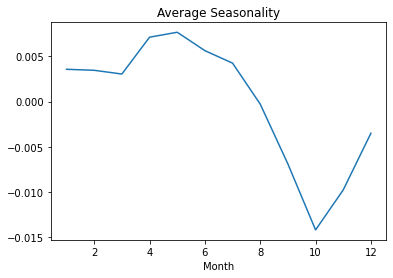

In [30]:
decomposition_year["Month"] = decomposition_year["Date"].dt.month
plt.plot(decomposition_year.groupby("Month")["seasonal"].mean())
plt.xlabel("Month")
plt.title("Average Seasonality")
plt.plot();

# Modeling

## SARIMA (monthly)

In [32]:
order = (1, 1, 1)
seasonal_order = (1, 0, 1, 12)
sarima_model = SARIMAX(monthly_data['Log_Close'], order=order, seasonal_order=seasonal_order).fit()
sarima_forecast = sarima_model.get_forecast(steps=12)
display(sarima_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          Log_Close   No. Observations:                  850
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                1479.361
Date:                            Thu, 04 Apr 2024   AIC                          -2948.723
Time:                                    19:35:30   BIC                          -2925.002
Sample:                                         0   HQIC                         -2939.636
                                            - 850                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6845      0.217     -3.148      0.002      -1.111      -0.258
ma.L1          0.7341      0.205      3.583      0.000       0.333       1.136
ar.S.L12       0.2772      1.029      0.269      0.788      -1.740       2.295
ma.S.L12      -0.2432      1.037     -0.235      0.814      -2.275       1.788
sigma2         0.0018   5.97e-05     30.049      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               412.39
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                            -0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

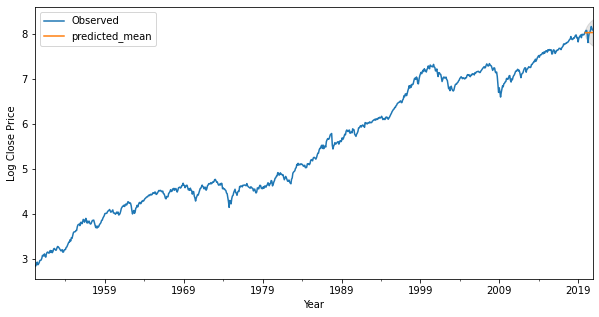

In [37]:
futureDF_forecast, next_periods_ci = forecast_with_sarimax(monthly_data.set_index("Date")['Log_Close'], 12, order=order,
                                                           seasonal_order=seasonal_order, offset = 0)

## Prophet (monthly)

19:36:11 - cmdstanpy - INFO - Chain [1] start processing
19:36:12 - cmdstanpy - INFO - Chain [1] done processing


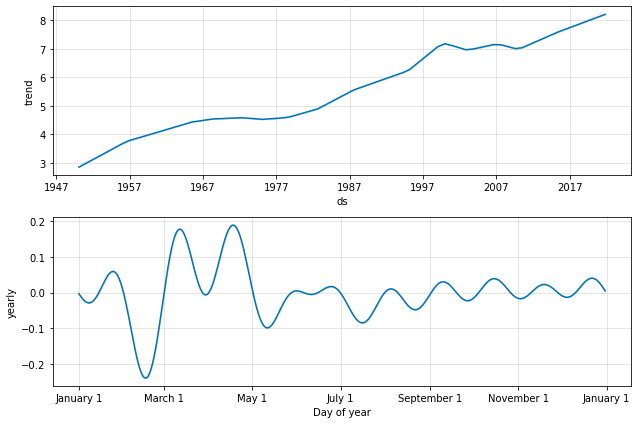

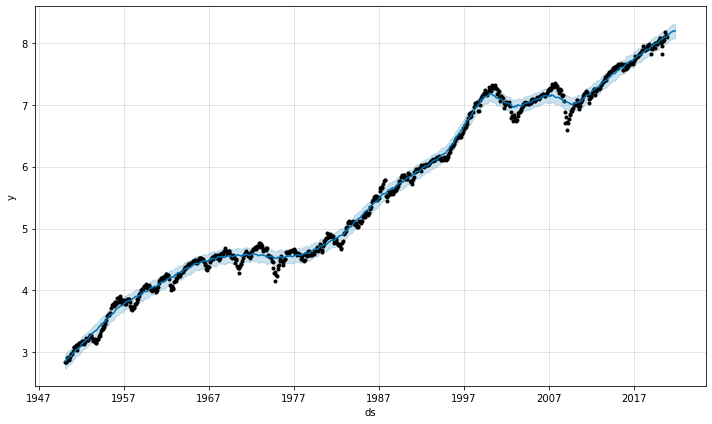

In [38]:
monthly_data_prophet = monthly_data.rename({"Date": "ds", "Log_Close": "y"}, axis =1)
m = Prophet(changepoint_range = 0.95, n_changepoints=70)
m.fit(monthly_data_prophet)
future_dates = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

## Prophet (yealy)

In [ ]:
# sp500_prophet = sp500.rename({"Date": "ds", "Log_Close": "y"}, axis =1)
# m = Prophet(changepoint_range = 0.95, n_changepoints=70)
# m.fit(sp500_prophet)
# future_dates = m.make_future_dataframe(periods=365)
# forecast = m.predict(future_dates)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
# m.plot_components(forecast);
# m.plot(forecast);

In [ ]:
# pd.to_datetime([f'{year}-01-01' for year in [i*5 + 1960 for i in range(10)]])

In [ ]:
# # Trains on data up to the cutoff point
# cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*5 + 1960 for i in range(10)]])
# df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")

## LSTM

In [46]:
data = sp500.set_index("Date")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lr1e4_bs256

  | Name        | Type       | Params
-------------------------------------------
0 | lstm_layers | ModuleList | 71.6 K
1 | linear      | Linear     | 51    
-------------------------------------------
71.7 K    Trainable params
0         Non-trainable params
71.7 K    Total params
0.287     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


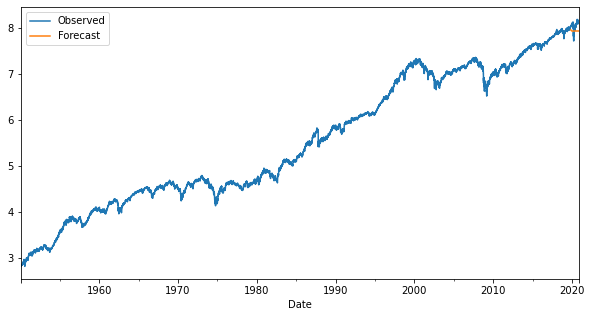

In [47]:
seq_length = 365
batch_size=256
input_size=1
hidden_layer_sizes=[100, 50]
prediction_len=1
learning_rate=1e-4
max_epochs=100

train_data, validation_data = split_data(data, validation_years=2)
train_sequences = create_inout_sequences(train_data['Log_Close'].tolist(), seq_length, prediction_len)
validation_sequences = create_inout_sequences(validation_data['Log_Close'].tolist(), seq_length, prediction_len)

train_loader = create_dataloader(train_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=False)
validation_loader = create_dataloader(validation_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=True)

model = train_model(train_loader, validation_loader, input_size, hidden_layer_sizes,
                    prediction_len, learning_rate, max_epochs, name = "lr1e4_bs256")

data = predict_iterativly(data, add_forcast_to_frame = True)
plot_org_w_pred(data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lr1e4_bs64

  | Name        | Type       | Params
-------------------------------------------
0 | lstm_layers | ModuleList | 71.6 K
1 | linear      | Linear     | 51    
-------------------------------------------
71.7 K    Trainable params
0         Non-trainable params
71.7 K    Total params
0.287     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


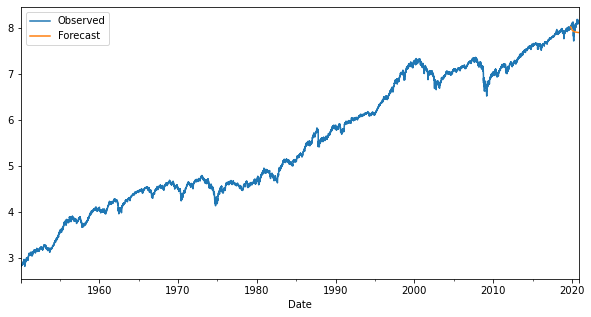

In [48]:
seq_length = 365
batch_size=64
input_size=1
hidden_layer_sizes=[100, 50]
prediction_len=1
learning_rate=1e-4
max_epochs=100

train_data, validation_data = split_data(data, validation_years=2)
train_sequences = create_inout_sequences(train_data['Log_Close'].tolist(), seq_length, prediction_len)
validation_sequences = create_inout_sequences(validation_data['Log_Close'].tolist(), seq_length, prediction_len)

train_loader = create_dataloader(train_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=False)
validation_loader = create_dataloader(validation_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=True)

model = train_model(train_loader, validation_loader, input_size, hidden_layer_sizes,
                    prediction_len, learning_rate, max_epochs, name = "lr1e4_bs64")

data = predict_iterativly(data, add_forcast_to_frame = True)
plot_org_w_pred(data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lr1e-5

  | Name        | Type       | Params
-------------------------------------------
0 | lstm_layers | ModuleList | 71.6 K
1 | linear      | Linear     | 51    
-------------------------------------------
71.7 K    Trainable params
0         Non-trainable params
71.7 K    Total params
0.287     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


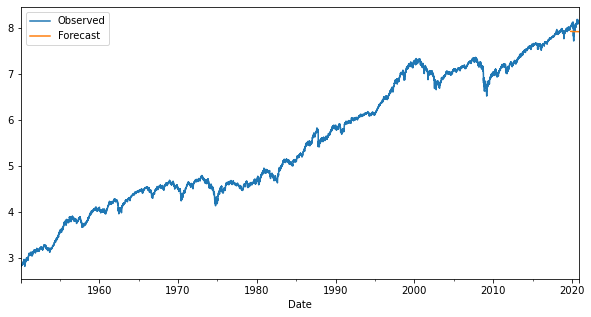

In [49]:
seq_length = 365
batch_size=128
input_size=1
hidden_layer_sizes=[100, 50]
prediction_len=1
learning_rate=1e-5
max_epochs=100

train_data, validation_data = split_data(data, validation_years=2)
train_sequences = create_inout_sequences(train_data['Log_Close'].tolist(), seq_length, prediction_len)
validation_sequences = create_inout_sequences(validation_data['Log_Close'].tolist(), seq_length, prediction_len)

train_loader = create_dataloader(train_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=False)
validation_loader = create_dataloader(validation_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=True)

model = train_model(train_loader, validation_loader, input_size, hidden_layer_sizes,
                    prediction_len, learning_rate, max_epochs, name = "lr1e-5")

data = predict_iterativly(data, add_forcast_to_frame = True)
plot_org_w_pred(data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lr1e-4_years

  | Name        | Type       | Params
-------------------------------------------
0 | lstm_layers | ModuleList | 71.6 K
1 | linear      | Linear     | 51    
-------------------------------------------
71.7 K    Trainable params
0         Non-trainable params
71.7 K    Total params
0.287     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


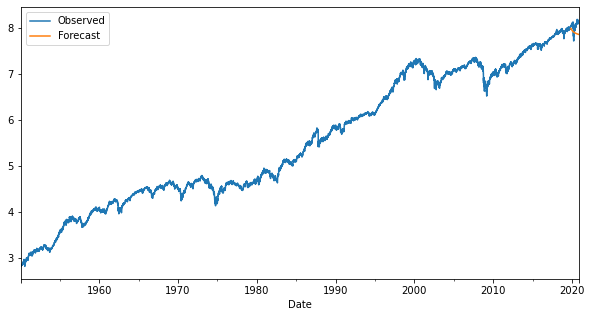

In [50]:
seq_length = 365*2
batch_size=128
input_size=1
hidden_layer_sizes=[100, 50]
prediction_len=1
learning_rate=0.0001
max_epochs=100

train_data, validation_data = split_data(data, validation_years=2)
train_sequences = create_inout_sequences(train_data['Log_Close'].tolist(), seq_length, prediction_len)
validation_sequences = create_inout_sequences(validation_data['Log_Close'].tolist(), seq_length, prediction_len)

train_loader = create_dataloader(train_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=False)
validation_loader = create_dataloader(validation_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=True)

model = train_model(train_loader, validation_loader, input_size, hidden_layer_sizes,
                    prediction_len, learning_rate, max_epochs, name = "lr1e-4_years")

data = predict_iterativly(data, add_forcast_to_frame = True)
plot_org_w_pred(data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type       | Params
-------------------------------------------
0 | lstm_layers | ModuleList | 71.6 K
1 | linear      | Linear     | 51    
-------------------------------------------
71.7 K    Trainable params
0         Non-trainable params
71.7 K    Total params
0.287     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


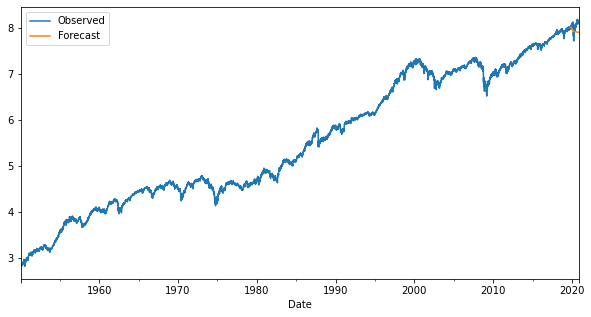

In [51]:
seq_length = 365
batch_size=128
input_size=1
hidden_layer_sizes=[100, 50]
prediction_len=1
learning_rate=0.0001
max_epochs=100

train_data, validation_data = split_data(data, validation_years=2)
train_sequences = create_inout_sequences(train_data['Log_Close'].tolist(), seq_length, prediction_len)
validation_sequences = create_inout_sequences(validation_data['Log_Close'].tolist(), seq_length, prediction_len)

train_loader = create_dataloader(train_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=False)
validation_loader = create_dataloader(validation_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=True)

model = train_model(train_loader, validation_loader, input_size, hidden_layer_sizes,
                    prediction_len, learning_rate, max_epochs, name = "lr1e-4")

data = predict_iterativly(data, add_forcast_to_frame = True)
plot_org_w_pred(data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lr1e-4_75_50

  | Name        | Type       | Params
-------------------------------------------
0 | lstm_layers | ModuleList | 48.8 K
1 | linear      | Linear     | 51    
-------------------------------------------
48.9 K    Trainable params
0         Non-trainable params
48.9 K    Total params
0.195     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.


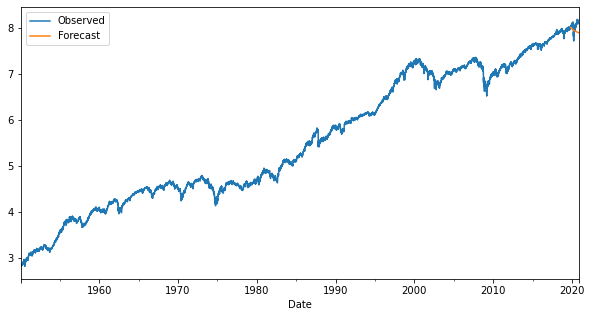

In [52]:
seq_length = 365
batch_size=128
input_size=1
hidden_layer_sizes=[75, 50]
prediction_len=1
learning_rate=0.0001
max_epochs=100

train_data, validation_data = split_data(data, validation_years=2)
train_sequences = create_inout_sequences(train_data['Log_Close'].tolist(), seq_length, prediction_len)
validation_sequences = create_inout_sequences(validation_data['Log_Close'].tolist(), seq_length, prediction_len)

train_loader = create_dataloader(train_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=False)
validation_loader = create_dataloader(validation_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=True)

model = train_model(train_loader, validation_loader, input_size, hidden_layer_sizes,
                    prediction_len, learning_rate, max_epochs, name = "lr1e-4_75_50")

data = predict_iterativly(data, add_forcast_to_frame = True)
plot_org_w_pred(data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lr1e4_bs64_2_years

  | Name        | Type       | Params
-------------------------------------------
0 | lstm_layers | ModuleList | 71.6 K
1 | linear      | Linear     | 51    
-------------------------------------------
71.7 K    Trainable params
0         Non-trainable params
71.7 K    Total params
0.287     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=150` reached.


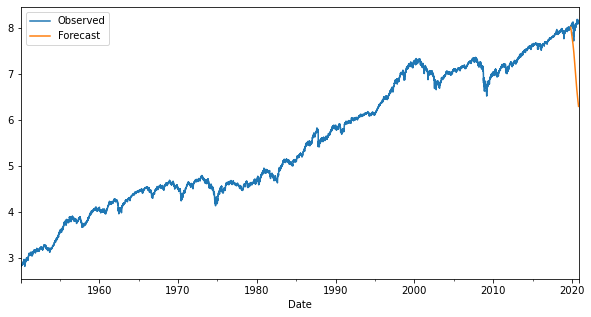

In [53]:
seq_length = 365*2
batch_size=64
input_size=1
hidden_layer_sizes=[100, 50]
prediction_len=1
learning_rate=1e-4
max_epochs=150

train_data, validation_data = split_data(data, validation_years=2)
train_sequences = create_inout_sequences(train_data['Log_Close'].tolist(), seq_length, prediction_len)
validation_sequences = create_inout_sequences(validation_data['Log_Close'].tolist(), seq_length, prediction_len)

train_loader = create_dataloader(train_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=False)
validation_loader = create_dataloader(validation_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=True)

model = train_model(train_loader, validation_loader, input_size, hidden_layer_sizes,
                    prediction_len, learning_rate, max_epochs, name = "lr1e4_bs64_2_years")

data = predict_iterativly(data, add_forcast_to_frame = True)
plot_org_w_pred(data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lr1e4_bs32

  | Name        | Type       | Params
-------------------------------------------
0 | lstm_layers | ModuleList | 71.6 K
1 | linear      | Linear     | 51    
-------------------------------------------
71.7 K    Trainable params
0         Non-trainable params
71.7 K    Total params
0.287     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=150` reached.


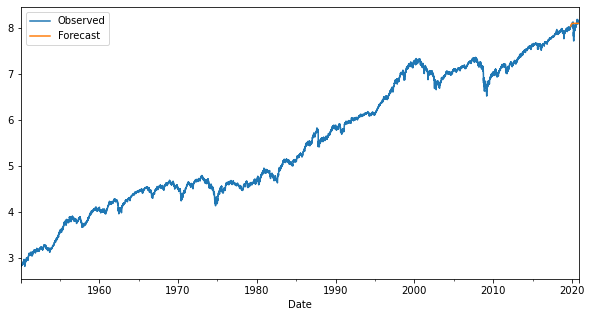

In [54]:
seq_length = 365
batch_size=32
input_size=1
hidden_layer_sizes=[100, 50]
prediction_len=1
learning_rate=1e-4
max_epochs=150

train_data, validation_data = split_data(data, validation_years=2)
train_sequences = create_inout_sequences(train_data['Log_Close'].tolist(), seq_length, prediction_len)
validation_sequences = create_inout_sequences(validation_data['Log_Close'].tolist(), seq_length, prediction_len)

train_loader = create_dataloader(train_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=False)
validation_loader = create_dataloader(validation_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=True)

model = train_model(train_loader, validation_loader, input_size, hidden_layer_sizes,
                    prediction_len, learning_rate, max_epochs, name = "lr1e4_bs32")

data = predict_iterativly(data, add_forcast_to_frame = True)
plot_org_w_pred(data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/lr1e4_bs64_epochs150

  | Name        | Type       | Params
-------------------------------------------
0 | lstm_layers | ModuleList | 71.6 K
1 | linear      | Linear     | 51    
-------------------------------------------
71.7 K    Trainable params
0         Non-trainable params
71.7 K    Total params
0.287     Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=150` reached.


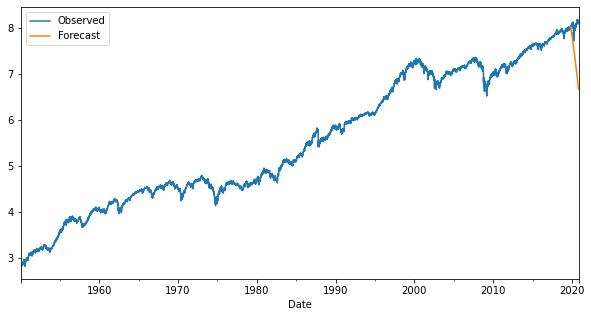

In [55]:
seq_length = 365
batch_size=64
input_size=1
hidden_layer_sizes=[100, 50]
prediction_len=1
learning_rate=1e-4
max_epochs=150

train_data, validation_data = split_data(data, validation_years=2)
train_sequences = create_inout_sequences(train_data['Log_Close'].tolist(), seq_length, prediction_len)
validation_sequences = create_inout_sequences(validation_data['Log_Close'].tolist(), seq_length, prediction_len)

train_loader = create_dataloader(train_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=False)
validation_loader = create_dataloader(validation_sequences, batch_size, shuffle=True, num_workers=4, persistent_workers=True)

model = train_model(train_loader, validation_loader, input_size, hidden_layer_sizes,
                    prediction_len, learning_rate, max_epochs, name = "lr1e4_bs64_epochs150")

data = predict_iterativly(data, add_forcast_to_frame = True)
plot_org_w_pred(data)

In [ ]:
def predict_x_steps(model, data):
    model(data)

In [ ]:
cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*5 + 1960 for i in range(10)]])
fold_train = data

# appendix

Defalut

12:51:09 - cmdstanpy - INFO - Chain [1] start processing
12:51:33 - cmdstanpy - INFO - Chain [1] done processing


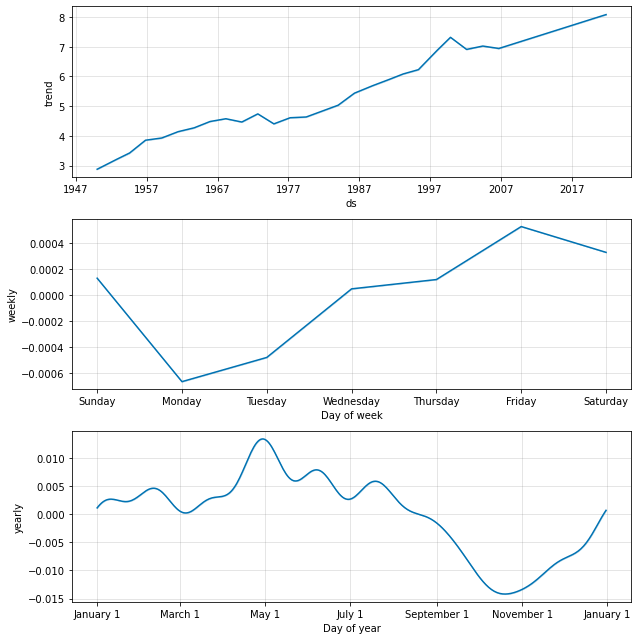

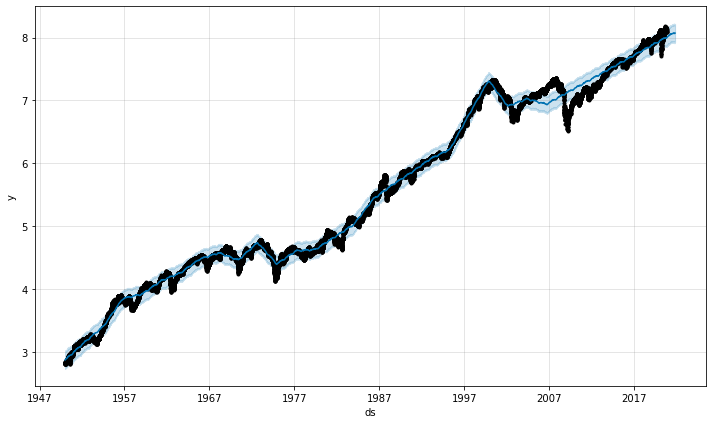

In [13]:
sp500_prophet = sp500.rename({"Date": "ds", "Log_Close": "y"}, axis =1)
m = Prophet()
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

changepoint_range = 0.95

12:51:45 - cmdstanpy - INFO - Chain [1] start processing
12:52:01 - cmdstanpy - INFO - Chain [1] done processing


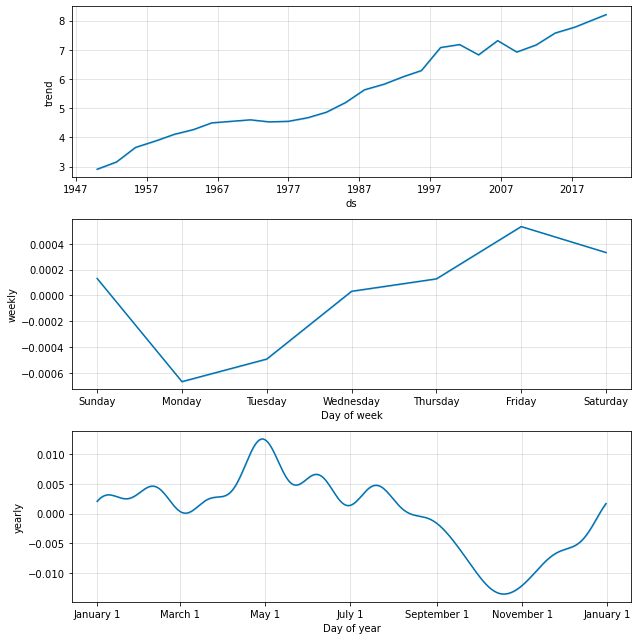

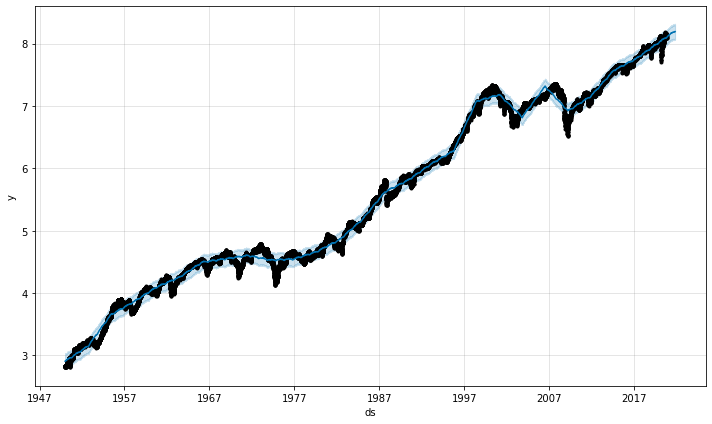

In [14]:
m = Prophet(changepoint_range = 0.95)
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

12:59:49 - cmdstanpy - INFO - Chain [1] start processing
13:02:01 - cmdstanpy - INFO - Chain [1] done processing


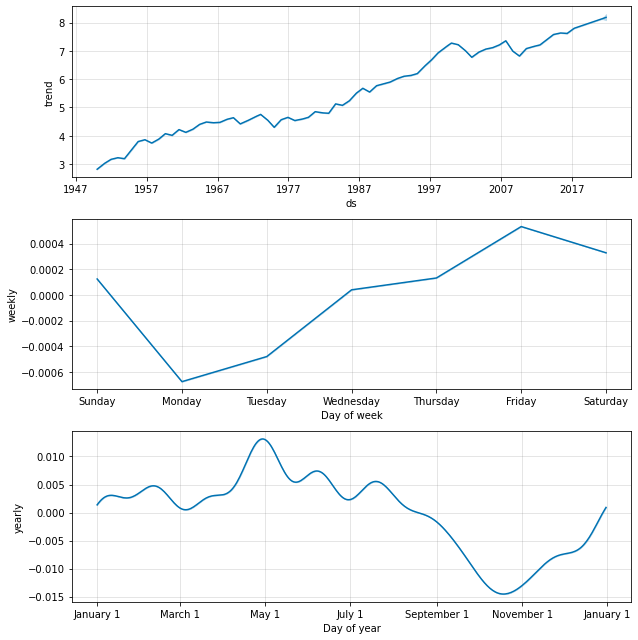

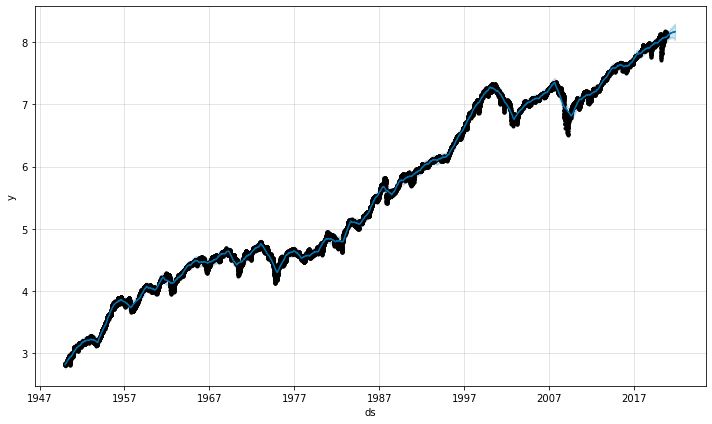

In [18]:
m = Prophet(changepoint_range = 0.95, n_changepoints=70)
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

Holidays

16:06:01 - cmdstanpy - INFO - Chain [1] start processing
16:06:25 - cmdstanpy - INFO - Chain [1] done processing


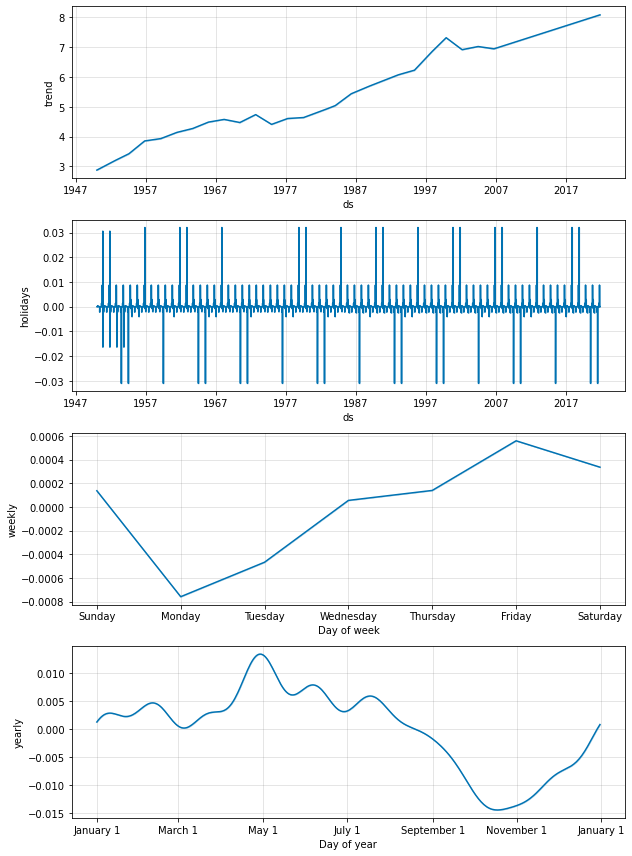

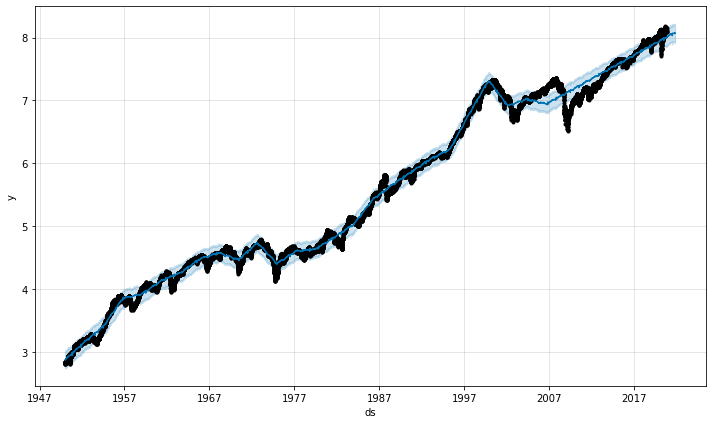

In [184]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(sp500_prophet)
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

Volume + changepoint_range 0.95

16:49:00 - cmdstanpy - INFO - Chain [1] start processing
16:49:14 - cmdstanpy - INFO - Chain [1] done processing


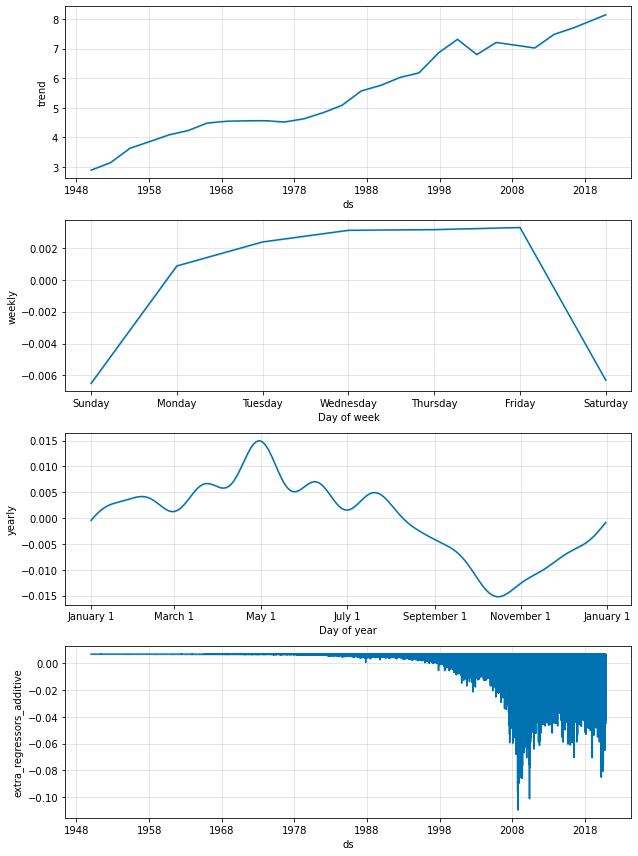

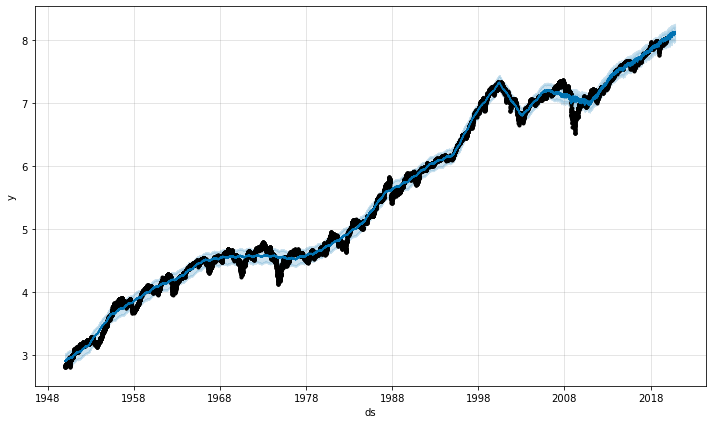

In [221]:
m = Prophet(changepoint_range = 0.95)
m.add_regressor("Volume")
m.fit(sp500_prophet[:-365])
future_dates = m.make_future_dataframe(periods=365)
future_dates['Volume'] = sp500_prophet['Volume']
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

with monthly seasonality

16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing


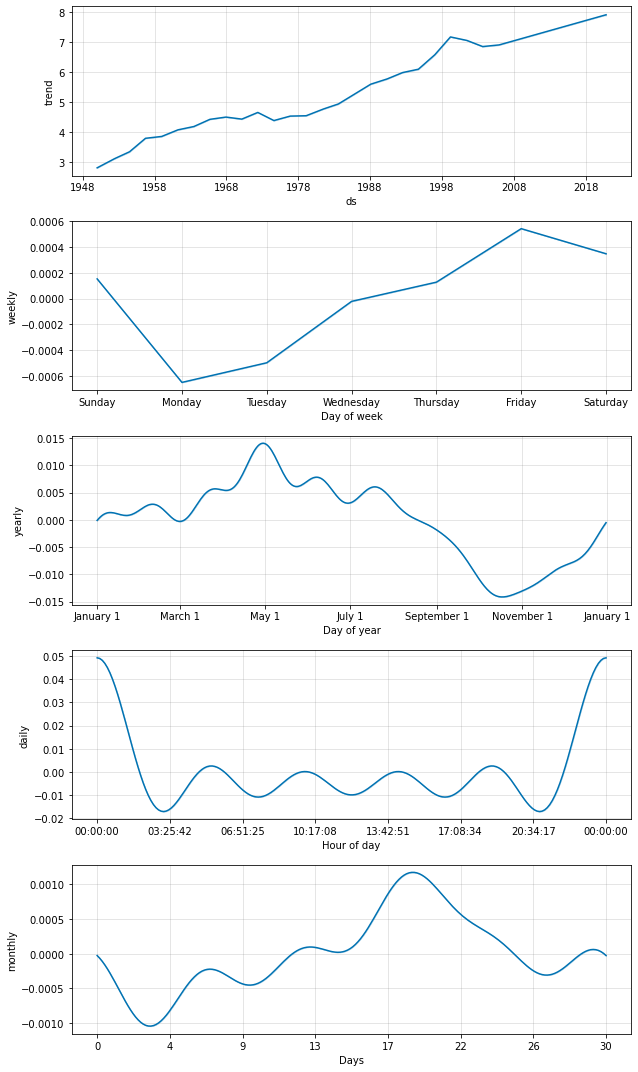

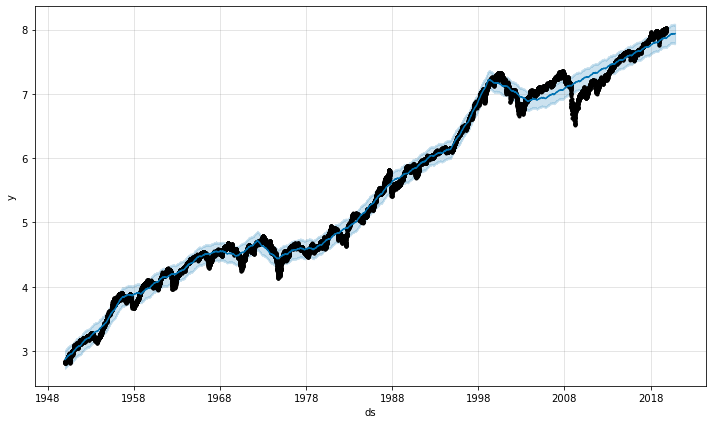

In [42]:
m = Prophet()
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.fit(sp500_prophet[:-365])
future_dates = m.make_future_dataframe(periods=365)
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

In [188]:
def years_until_next_election(year):
    return (4 - (year % 4)) % 4

def fill_party_periods(periods, party):
    return {year: party for start, end in periods for year in range(start, end)}

def generate_presidential_parties():
    democrat_periods = [(1940, 1952), (1961, 1969), (1977, 1981), (1993, 2001), (2009, 2017), (2021, 2024)]
    republican_periods = [(1953, 1961), (1969, 1977), (1981, 1993), (2001, 2009), (2017, 2021)]
    parties = {}
    parties.update(fill_party_periods(democrat_periods, 'Democrat'))
    parties.update(fill_party_periods(republican_periods, 'Republican'))
    return parties

def generate_president_party_dataset(last_year=2023):
    presidential_parties = generate_presidential_parties()
    start_date = '1940-01-01'
    end_date = f'{last_year}-12-31'
    dates = pd.date_range(start=start_date, end=end_date, freq='D')

    data = {'Date': [], 'Years Until Next US Election': [], 'Presidential Party': []}
    for date in dates:
        year = date.year
        party = presidential_parties.get(year, 'Unknown')
        data['Date'].append(date)
        data['Years Until Next US Election'].append(years_until_next_election(year))
        data['Presidential Party'].append(party)
    
    df = pd.DataFrame(data)
    return df

president_party_df = generate_president_party_dataset()
president_party_df['Democrat'] = president_party_df['Presidential Party'] == 'Democrat'
president_party_df['Republican'] = president_party_df['Presidential Party'] == 'Republican'
president_party_df['Democrat'] = president_party_df['Democrat'].astype(int)
president_party_df['Republican'] = president_party_df['Republican'].astype(int)


In [193]:
sp500_prophet_enriched = sp500_prophet.merge(president_party_df[['Date', 'Years Until Next US Election', 
                                                                 'Democrat', 'Republican']],
                                             left_on='ds', right_on='Date', how='left')

Democrat party regressor

16:07:47 - cmdstanpy - INFO - Chain [1] start processing
16:08:04 - cmdstanpy - INFO - Chain [1] done processing


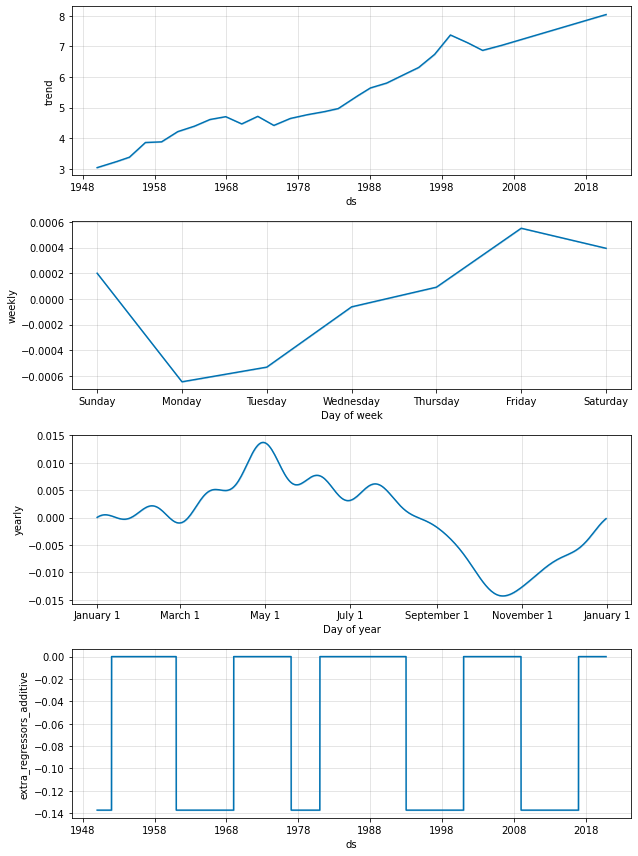

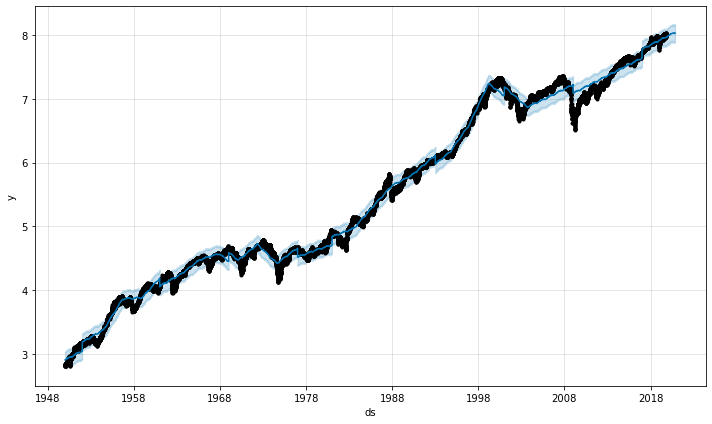

In [190]:
m = Prophet()
# m.add_regressor("Years Until Next US Election")
m.add_regressor("Democrat")
m.fit(sp500_prophet_enriched[:-365])
future_dates = m.make_future_dataframe(periods=365)
future_dates['Democrat'] = sp500_prophet_enriched['Democrat']
# future_dates['Years Until Next US Election'] = sp500_prophet_enriched['Years Until Next US Election']
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

In [ ]:
Democrat Republican, seasonality

16:15:22 - cmdstanpy - INFO - Chain [1] start processing
16:15:53 - cmdstanpy - INFO - Chain [1] done processing


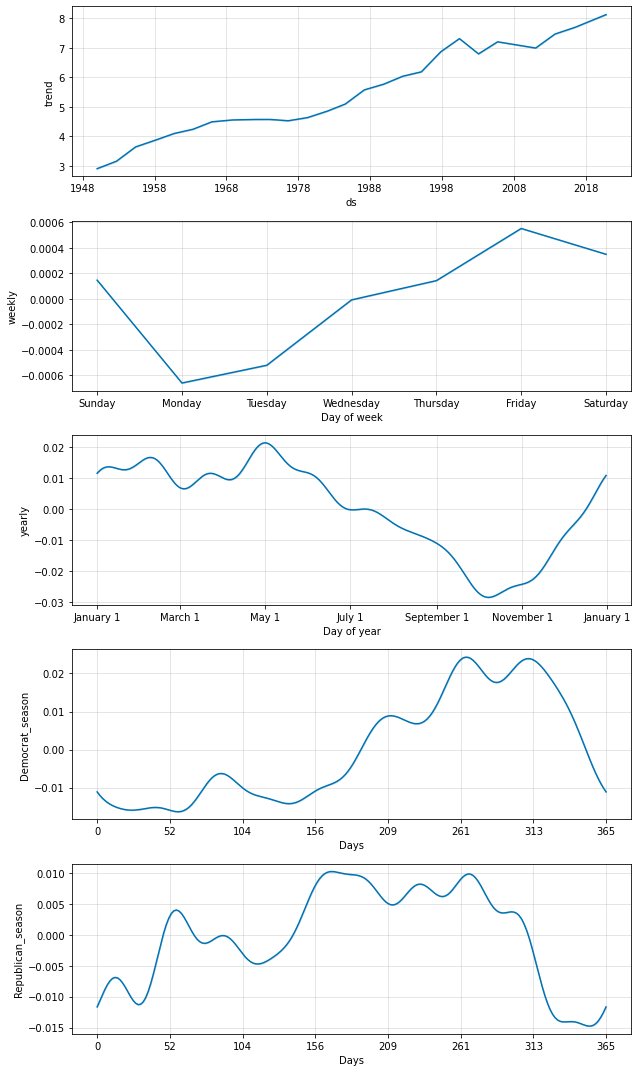

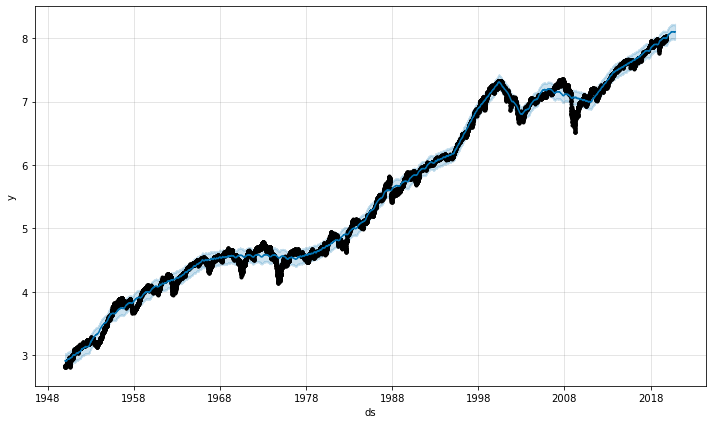

In [195]:
m = Prophet(changepoint_range = 0.95)
# m.add_regressor("Years Until Next US Election")
m.add_seasonality(name='Democrat_season', period=365, fourier_order=10, condition_name='Democrat')
m.add_seasonality(name='Republican_season', period=365, fourier_order=10, condition_name='Republican')
m.fit(sp500_prophet_enriched[:-365])
future_dates = m.make_future_dataframe(periods=365)
future_dates['Democrat'] = sp500_prophet_enriched['Democrat']
future_dates['Republican'] = sp500_prophet_enriched['Republican']
# future_dates['Years Until Next US Election'] = sp500_prophet_enriched['Years Until Next US Election']
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

cross validation

In [204]:
cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*5 + 1960 for i in range(12)]])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")

  0%|          | 0/12 [00:00<?, ?it/s]

16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing
16:25:45 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1] done processing
16:26:07 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1]

In [220]:
performance_metrics(df_cv, rolling_window=0)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,1 days,0.004991,0.070647,0.047767,0.008133,0.006869,0.008173,0.833333
1,2 days,0.005055,0.071097,0.049558,0.008514,0.007680,0.008553,0.833333
2,3 days,0.005737,0.075745,0.052922,0.008994,0.007580,0.009034,0.833333
3,4 days,0.005858,0.076537,0.054681,0.009312,0.007859,0.009354,0.750000
4,5 days,0.005991,0.077401,0.055563,0.009406,0.007558,0.009450,0.833333
...,...,...,...,...,...,...,...,...
360,361 days,0.075474,0.274725,0.216659,0.039015,0.028109,0.040147,0.416667
361,362 days,0.075554,0.274872,0.216065,0.038965,0.027944,0.040112,0.500000
362,363 days,0.075736,0.275201,0.216113,0.038881,0.026647,0.040012,0.583333
363,364 days,0.076483,0.276555,0.217155,0.039030,0.026840,0.040172,0.333333
